# Fit

### Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import emcee
import os
import corner

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=26)

### Functions

In [43]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary * vrot
    v_y = x_unitary * vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    n,b,p = plt.hist(-data_theta['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='black',
                 linewidth=lw, bins=30, alpha=alpha, label=label)
    return np.max(n)

In [30]:
def model(vrot, vout, logtau, theta, x_d, y_d):
    
    v_th=12.86
    
    data = read_data(vout=vout, vrot=0, logtau=logtau)
    data_doppler = doppler_shift(data, vrot=vrot)
    data_theta = filter_by_theta(data_doppler, theta, theta+0.1)
    
    n, b = np.histogram(-data_theta['x_frec']*v_th, normed=True, bins=50)
    
    x_m = []
    for i in range(1,len(b)):
        x_m.append((b[i-1]+b[i])/2)
    
    n_max = np.max(n)
    y_m = n * np.max(y_d) / n_max

    return x_m, y_m

In [17]:
#emcee functions

def lnprior(param):

    vrot, vout, logtau, theta = param
    
    if (logtau in [5,6,7]) and (vout in [5,25,50,100]) and (0<theta<90) and (0<vrot<150):
        return 0.0

    return -np.inf


def lnlike(param, x_d, y_d):

    vrot, vout, logtau, theta = param

    x_m, y_m = model(vrot, vout, logtau, theta, x_d, y_d)

    chi_squared = 0.5*sum((y_d-y_m)**2)

    print('chi squared {}'.format(chi_squared))
    return -chi_squared


def lnprob(param, x_d, y_d):

    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(param, x_d, y_d)

### Data

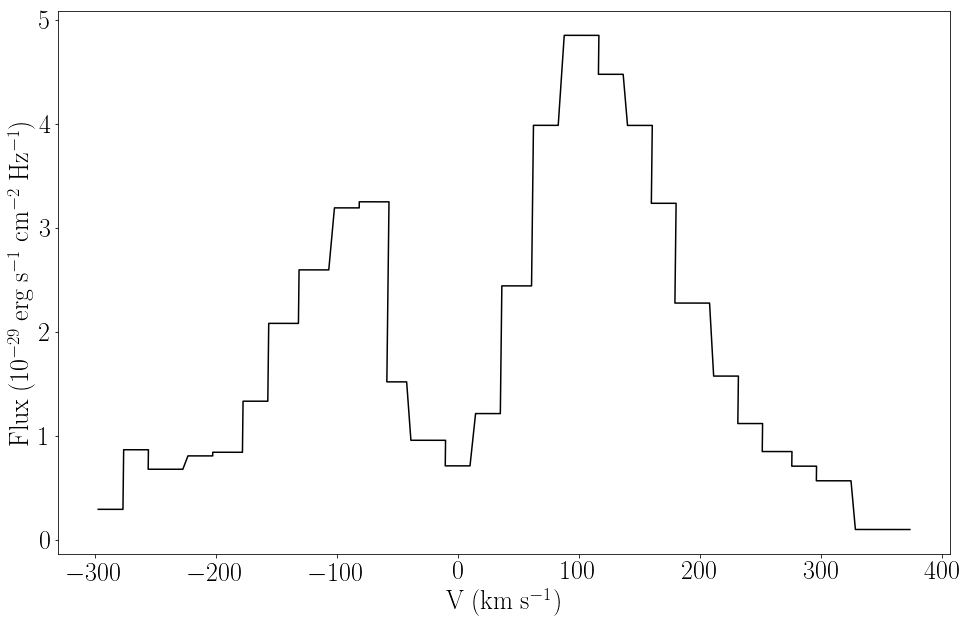

In [18]:
data = np.loadtxt('./discussion/kulas.csv', delimiter=',')

x = data[:,0]/(1+2.5954) #redshift z = 2.5954
y = data[:,1]

f = plt.figure(figsize = (16,10))
plt.plot(x, y, c='black')
plt.xlabel('$\mathrm{V\;(km\;s^{-1})}$')
plt.ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')

### Emcee

/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Mean acceptance fraction: 0.000 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
vrot =  [  99.99961988  100.00022568  100.00098169]
vout =  [ 24.99877335  24.99992856  25.00174767]
logtau =  [ 4.99959016  5.0002344   5.00156489]
theta =  [-0.001656   -0.00032909  0.00125343]


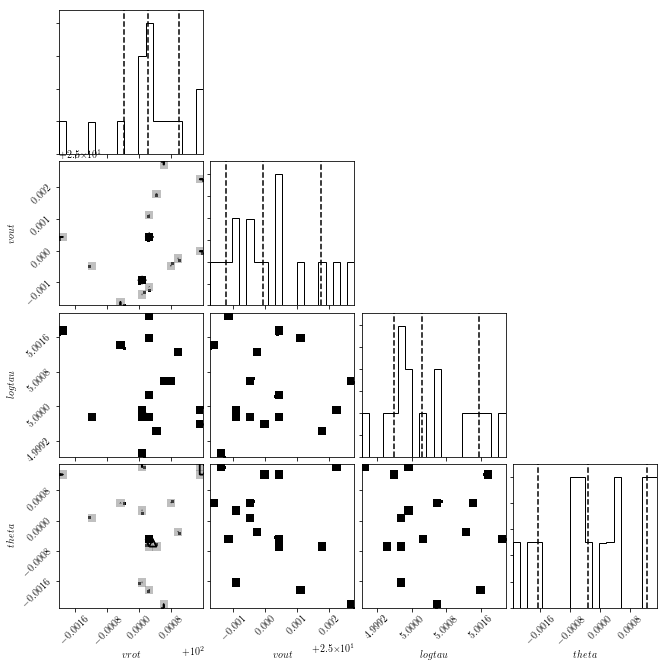

In [21]:
first_guess = [100, 25, 5, 0]

#Running emcee
ndim = 4
nwalkers = 16
nsteps = 5000

pos = [first_guess+ 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y), threads=8)

sampler.run_mcmc(pos, nsteps, rstate0=np.random.get_state())

# Saving results
samples_fc = sampler.flatchain
logprob_fc = sampler.flatlnprobability

#This number should be between approximately 0.25 and 0.5 if everything went as planned.
print("Mean acceptance fraction: {0:.3f} (Should be between 0.25 and 0.5 approximately)".format(np.mean(sampler.acceptance_fraction)))

#Discard the initial 50 steps
samples = samples_fc[50:]
logprob = logprob_fc[50:]

# Unpack the walk for each parameter
vrot_walk, vout_walk, logtau_walk, theta_walk = np.transpose(samples)

# Extract the percentiles for each parameter
vrot_mcmc = np.percentile(vrot_walk, [16, 50, 84])
vout_mcmc = np.percentile(vout_walk, [16, 50, 84])
logtau_mcmc = np.percentile(logtau_walk, [16, 50, 84])
theta_mcmc = np.percentile(theta_walk, [16, 50, 84])

# Takes the best parameters as the 50 percentile
vrot_best = vrot_walk[1]
vout_best = vout_walk[1]
logtau_best = logtau_walk[1]
theta_best = theta_walk[1]

# Prints them
print('Parameter = [16 50 84]')
print('vrot = ', vrot_mcmc)
print('vout = ', vout_mcmc)
print('logtau = ', logtau_mcmc)
print('theta = ', theta_mcmc)

fig = corner.corner(samples,
                    labels = ["$vrot$", "$vout$", "$logtau$", "$theta$"],
                    quantiles = [0.16, 0.5,0.84])

In [68]:
data = np.loadtxt('./discussion/kulas.csv', delimiter=',')

x = data[:,0]/(1+2.5954) #redshift z = 2.5954
y = data[:,1]
y = y - min(y)

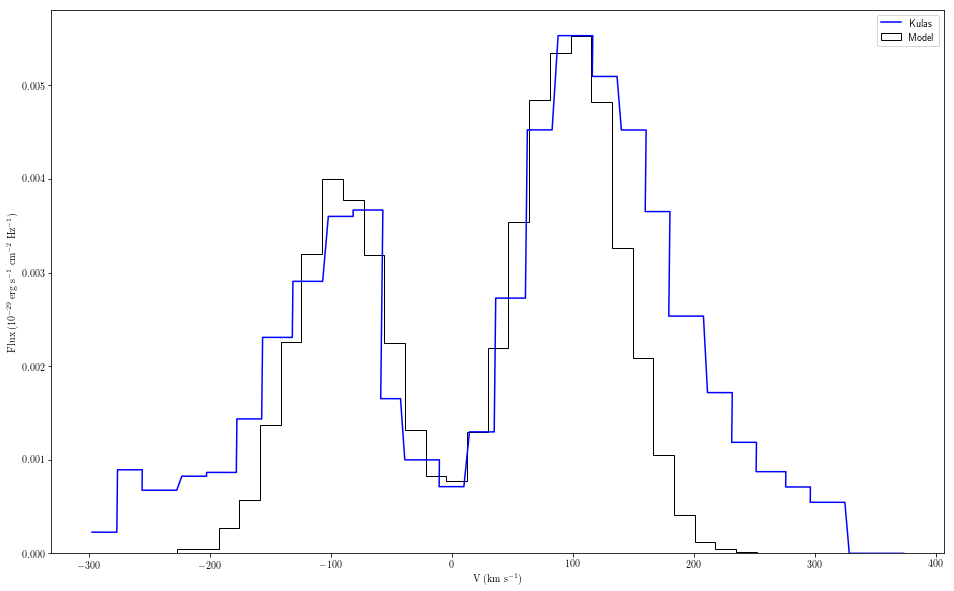

In [72]:
data_model = read_data(vout=5, vrot=0, logtau=6)
data_doppler = doppler_shift(data_model, vrot=100)

f = plt.figure(figsize = (16,10))
m = plot_spectra(data_doppler, 0.55, 0.75, lw=1, label='Model')
plt.plot(x, y*m/np.max(y), c='blue', label='Kulas')
plt.xlabel('$\mathrm{V\;(km\;s^{-1})}$')
plt.ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
plt.legend()

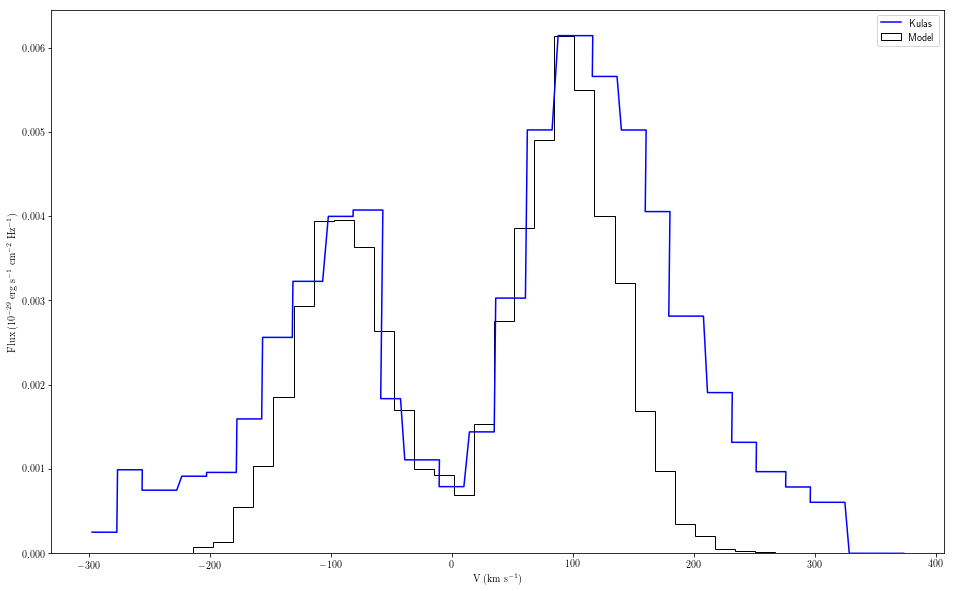

In [73]:
data_model = read_data(vout=5, vrot=0, logtau=6)
data_doppler = doppler_shift(data_model, vrot=150)

f = plt.figure(figsize = (16,10))
m = plot_spectra(data_doppler, 0.3, 0.5, lw=1, label='Model')
plt.plot(x, y*m/np.max(y), c='blue', label='Kulas')
plt.xlabel('$\mathrm{V\;(km\;s^{-1})}$')
plt.ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
plt.legend()

/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


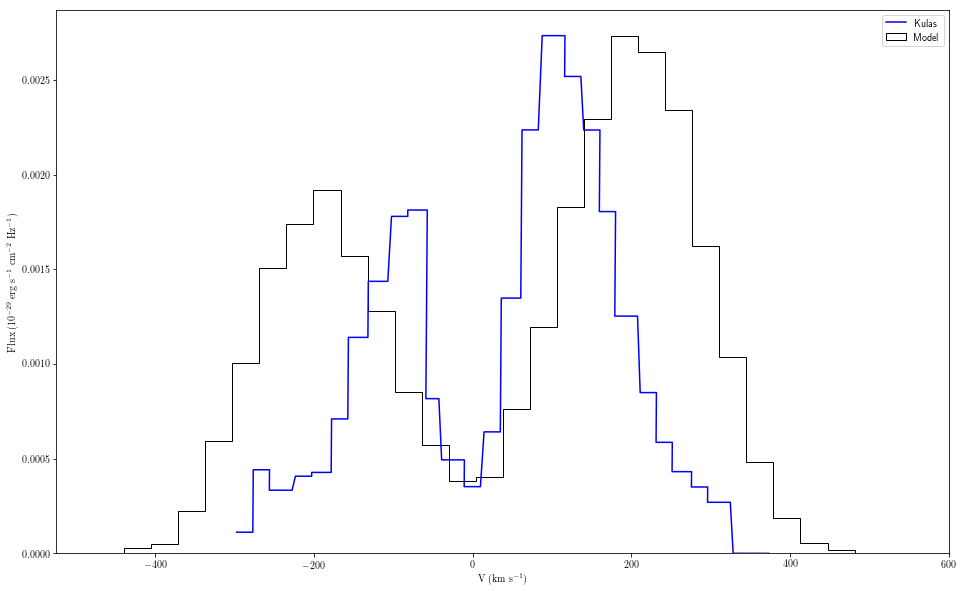

In [79]:
data_model = read_data(vout=5, vrot=0, logtau=7)
data_doppler = doppler_shift(data_model, vrot=150)

f = plt.figure(figsize = (16,10))
m = plot_spectra(data_doppler, 0.8, 1, lw=1, label='Model')
plt.plot(x, y*m/np.max(y), c='blue', label='Kulas')
plt.xlabel('$\mathrm{V\;(km\;s^{-1})}$')
plt.ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
plt.legend()